In [2]:
import numpy as np
import glob
import os
import netCDF4
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate
from scipy import ndimage
from mpl_toolkits.basemap import Basemap
from matplotlib import rcParams
%matplotlib inline

In [3]:
rcParams.update({'font.size': 18})

In [4]:
datadir = "/data_local/DataOceano/AVISO/ABACUS"
datafilelist = sorted(glob.glob(os.path.join(datadir, '*nc')))
figdir = "/home/ctroupin/Projects/3-European/201603_Abacus/figures/Peachi/"
mdtfile = "/data_local/DataOceano/AVISO/MDT/MDT_SOCIB_CLS.nc"
lonmin, lonmax = 1.0, 5.0

In [5]:
def readSLA40(datafile):
    with netCDF4.Dataset(datafilelist[0]) as nc:
        cycle_number = nc.cycle_number
        pass_number = nc.pass_number
        slatime = nc.variables['time_40hz'][:].ravel()
        lon = nc.variables['longitude_40hz'][:].ravel()
        lat = nc.variables['latitude_40hz'][:].ravel()
        sla = nc.variables['sea_level_anomaly_alti_40hz'][:].ravel()
        slaunits = nc.variables['sea_level_anomaly_alti_40hz'].units
        timeunits = nc.variables['time_40hz'].units
        sladate = netCDF4.num2date(slatime.min(), timeunits)
        return cycle_number, pass_number, lon, lat, sla, slatime, sladate

In [6]:
def select_region(lon, lat, sla, slatime, lonmin, latmin):
    # Select data in region of interest
    goodcoord = np.where(((lon>=lonmin) & (lon<=lonmax)) | (lon>360.))
    slatime = slatime[goodcoord]
    lon = lon[goodcoord]
    lat = lat[goodcoord]
    sla = sla[goodcoord]
    return lon, lat, sla, slatime

In [7]:
def create_title(sladate, cycle_number, pass_number):
    # Create title based on the info
    return ("%s\nCycle number: %s\n Pass number: %s" \
             %(sladate.strftime("%Y-%m-%d %H:%M:%S"), cycle_number, pass_number))

In [8]:
def createmap():
    m = Basemap(projection='merc',llcrnrlat=36.,urcrnrlat=42.,\
           llcrnrlon=-1.,urcrnrlon=6.,lat_ts=38,resolution='f')
    return m

In [9]:
def scatterplot_sla(m, lon, lat, sla, titletext, figname):
    lon2plot, lat2plot = m(lon, lat)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes()
    m.scatter(lon2plot, lat2plot, 5, sla, edgecolor='None')
    m.drawcoastlines(ax=ax, linewidth=0.5, zorder=3)
    m.fillcontinents(ax=ax, zorder=2)
    m.drawparallels(np.arange(36., 42., 1.0), linewidth=0.2, labels=[1, 0, 0, 0], zorder=1)
    m.drawmeridians(np.arange(-5., 6., 1.), linewidth=0.2, labels=[0, 0, 0, 1], zorder=1)
    plt.title(titletext, fontsize=22)
    cbar = plt.colorbar(ax=ax, shrink=0.85, extend='both')
    cbar.set_label('SLA (m)', rotation=0, ha='left')
    plt.savefig(figname, dpi=300)
    plt.close()

In [10]:
def plot_latsla(lat, sla, titletext, figname):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes()
    plt.plot(lat, sla, linewidth=0.2)
    plt.xlabel('Latitude ($^{\circ}$N)')
    plt.ylabel('SLA\n(m)', rotation=0, ha='right')
    plt.xlim(37.0, 39.5)
    plt.ylim(-0.15, 0.15)
    plt.title(titletext, fontsize=22)
    plt.savefig(figname, dpi=300)
    plt.close()

In [24]:
def plot_latsla_mdt(lat, sla, mdt, titletext, figname):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes()
    plt.plot(lat, sla, linewidth=0.2)
    plt.plot(lat, mdt, linewidth=2)
    plt.xlabel('Latitude ($^{\circ}$N)')
    plt.ylabel('SLA\n(m)', rotation=0, ha='right')
    plt.xlim(37.0, 39.5)
    plt.ylim(-0.15, 0.15)
    plt.title(titletext, fontsize=22)
    plt.show()

In [11]:
def plot_latsla_filtered(lat, sla, filteredsla, n1, titletext, figname):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes()
    plt.plot(lat, sla, linewidth=0.2)
    plt.plot(lat[:-n1/2], filteredsla[n1/2:], 'r')
    plt.xlabel('Latitude ($^{\circ}$N)')
    plt.ylabel('SLA\n(m)', rotation=0, ha='right')
    plt.xlim(37.0, 39.5)
    plt.ylim(-0.15, 0.15)
    plt.title(titletext, fontsize=22)
    plt.savefig(figname, dpi=300)
    plt.close()

In [12]:
def apply_filter(data):
    # For the filter, it is necessary to set:
    #  * the cutoff frequency,
    #  * the filter length,
    #  * the window applied to the filter
    n1 = 128  # filter length
    windowsname = 'blackman'  # windows name
    sample_rate = 40.  # 40 Hz data
    nyq_rate = sample_rate / 2.0  # Nyquist rate
    frqcut = 1.0 / (30 * 3600.)  # cutoff frequency
    cutoff = frqcut / nyq_rate  # Cutoff relative to Nyquist rate
    taps1 = signal.firwin(n1, cutoff=cutoff, window=(windowsname))
    filtereddata = signal.lfilter(taps1, 1.0, data)
    delay = 0.5 * (n1 - 1) / sample_rate
    filtereddata = np.ma.masked_outside(filtereddata, -1, 1)
    return filtereddata, delay, n1

In [13]:
def extractMDT(mdtfile, lon2interp, lat2interp):
    # interpolate the MDT on a list of coordinates
    with netCDF4.Dataset(mdtfile) as nc:
        lonMDT = nc.variables['lon'][:]
        latMDT = nc.variables['lat'][:]
        MDT = nc.variables['MDT'][:]
    # Grid necessary for interpolating
    llonMDT, llatMDT = np.meshgrid(lonMDT, latMDT)
    lonMDT2 = llonMDT.flatten(1)
    latMDT2 = llatMDT.flatten(1)
    dlonMDT = lonMDT[1] - lonMDT[0]
    dlatMDT = latMDT[1] - latMDT[0]
    lontrack_mapcoord = (lon2interp - lonMDT[0]) / dlonMDT
    lattrack_mapcoord = (lat2interp - latMDT[0]) / dlatMDT
    MDTinterp = ndimage.map_coordinates(MDT.T, np.array((lontrack_mapcoord, lattrack_mapcoord)), order=1)
    MDTinterp[np.abs(MDTinterp) > 1.] = 0.0
    return MDTinterp, lonMDT, latMDT, MDT

Working on /data_local/DataOceano/AVISO/ABACUS/PEACHI_ClipSLA_40Hz_C0016_P0773.nc


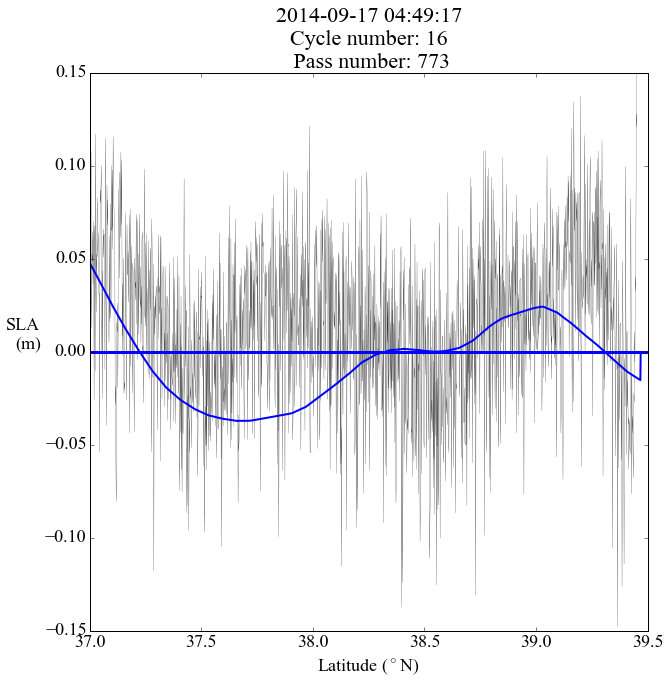

Working on /data_local/DataOceano/AVISO/ABACUS/PEACHI_ClipSLA_40Hz_C0018_P0773.nc


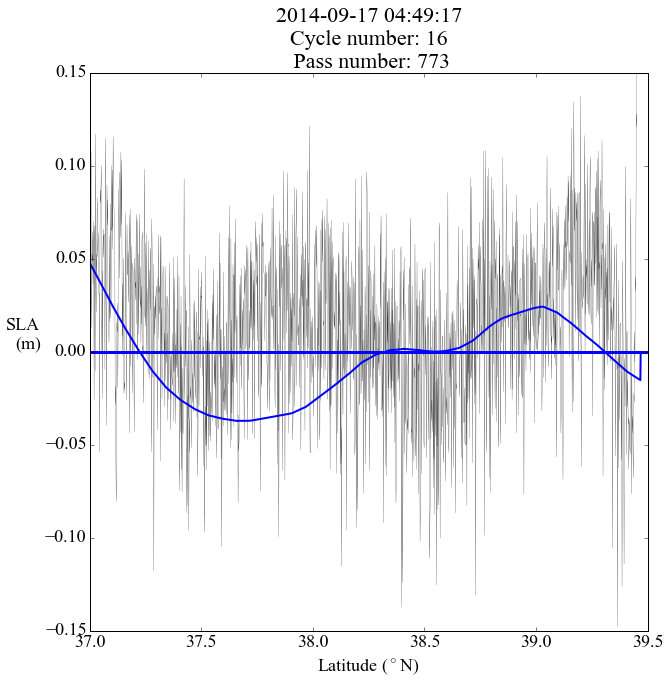

Working on /data_local/DataOceano/AVISO/ABACUS/PEACHI_ClipSLA_40Hz_C0019_P0229.nc


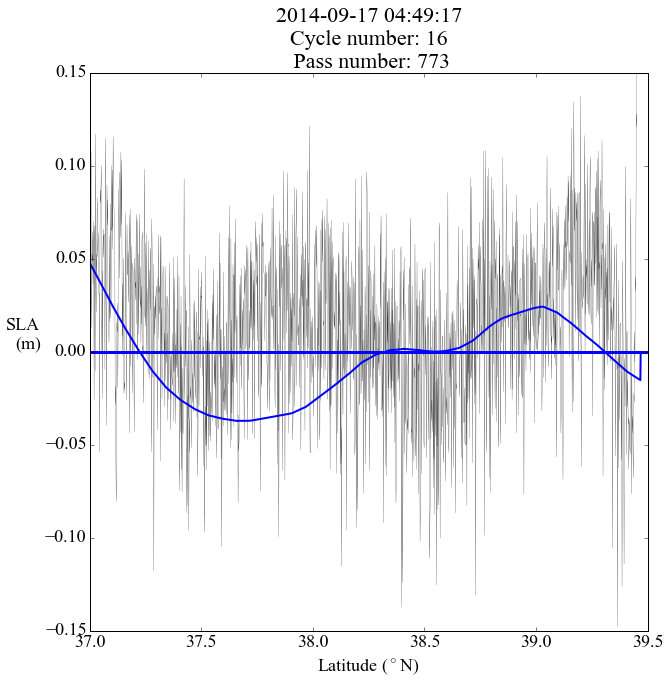

In [27]:
for datafiles in datafilelist:
    print("Working on %s" %(datafiles))
    figname1 = os.path.join(figdir, os.path.basename(datafiles)[:-3] + '_map')
    figname2 = os.path.join(figdir, os.path.basename(datafiles)[:-3] + '_track')
    figname3 = os.path.join(figdir, os.path.basename(datafiles)[:-3] + '_trackfiltered')
    
    cycle_number, pass_number, lon, lat, sla, slatime, sladate = readSLA40(readSLA40)
    lon, lat, sla, slatime = select_region(lon, lat, sla, slatime, lonmin, lonmax)
    titletext = create_title(sladate, cycle_number, pass_number)
    #m = createmap()
    #scatterplot_sla(m, lon, lat, sla, titletext, figname1)
    #filteredsla, delay, n1 = apply_filter(sla)
    #plot_latsla(lat, sla, titletext, figname2)
    #plot_latsla_filtered(lat, sla, filteredsla, n1, titletext, figname3)
    MDTinterp, lonMDT, latMDT, MDT = extractMDT(mdtfile, lon, lat)
    plot_latsla_mdt(lat, sla, MDTinterp, titletext, ' ')

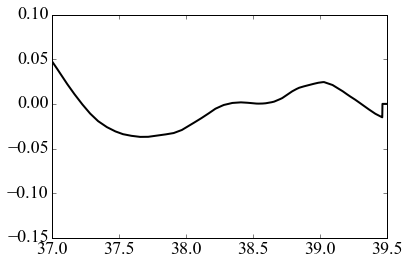

In [22]:
MDTinterp, lonMDT, latMDT, MDT = extractMDT(mdtfile, lon, lat)
lat = np.ma.masked_outside(lat, 35.0, 45.)
plt.plot(lat, MDTinterp)
plt.xlim(37., 39.5)
plt.show()

In [19]:
lat.min()
lat.max()

9.969209968386869e+36

In [88]:
MDTinterp.max()

0.075441256